In [1]:
import json
import pandas as pd 
import os

In [2]:
data = json.load(open('../vis/data/pulitzer-prize-records.json'))

In [3]:
data.keys()

dict_keys(['criticism', 'prize-categories', 'time-series-race', 'data', 'time-series-gender'])

In [5]:
# data['time-series-gender'][0]

In [6]:
data['data'][0]

{'Name (Individual)': 'Herbert Bayard Swope',
 'Prize Category': 'Reporting',
 'Gender': 'Male',
 'Prize Category (Corr)': 'Reporting',
 'Race': 'White',
 'Year': 1917.0,
 'Name (Paper, Current)': 'New York World Journal Tribune',
 'Name (Paper)': 'New York World'}

In [7]:
pd.DataFrame(data['data']).head()

,Gender,Name (Individual),Name (Paper),"Name (Paper, Current)",Prize Category,Prize Category (Corr),Race,Year
0,Male,Herbert Bayard Swope,New York World,New York World Journal Tribune,Reporting,Reporting,White,1917.0
1,Male,Harold A. Littledale,New York Evening Post,New York Post,Reporting,Reporting,White,1918.0
2,Female,Minna Lewinson (with Henry Beetle Hough),"School of Journalism, Columbia University","School of Journalism, Columbia University",Newspaper History Award,Newspaper History Award,White,1918.0
3,Male,Henry Beetle Hough (with Minna Lewinson),"School of Journalism, Columbia University","School of Journalism, Columbia University",Newspaper History Award,Newspaper History Award,White,1918.0
4,Male,John J. Leary,New York World,New York World Journal Tribune,Reporting,Reporting,White,1920.0


In [8]:
os.listdir('../data/')

['all_records_df.csv',
 'CCADMANUAL 2019 040319 - excl. SAR codes.pdf',
 'glove.6B.50d.txt',
 'merged_records_df.csv',
 'MO_codes.docx',
 'mo_codes_matched.csv',
 'nyt-corpus-crime-stores-lemmatized.csv',
 'nyt-corpus-crime-stores.csv',
 'raw_data.csv',
 'Xtown_ 2019 Hate Crime Write-Ups.txt',
 'Xtown_ Hate Crime Redesign - Sheet1.csv',
 '~$_codes.docx']

In [3]:
hate_crime_records = pd.read_csv('../data/merged_records_df.csv')

In [5]:
hate_crime_records.columns

Index(['Crime', 'Datetime', 'Description', 'Location_x', 'Neighborhood_x',
       'Suspect Actions', 'Weapon', 'Number', '@Photos', 'norm_date', 'Dr No',
       'Area ID', 'Area Name', 'Crm Cd', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Crm Cd Desc', 'Cross Street', 'Date Occ', 'Date Rp Td',
       'Latitude', 'Location_y', 'Location 1', 'Longitude', 'Mo Codes',
       'Neighborhood_y', 'Neighborhood Council', 'Prem Is Cd', 'Prem Is Desc',
       'Rpt Dist No', 'Status', 'Status Desc', 'Time Occ', 'Tract', 'Vict Age',
       'Vict Descent', 'Vict Sex', 'Weapon Desc', 'Weapon Used Cd',
       'Zip Code'],
      dtype='object')

In [10]:
hate_crime_records['Vict Descent'] = hate_crime_records['Vict Descent'].map({
    'H': 'Hispanic',
    'B': 'Black',
    'W': 'White',
    'X': 'Unknown',
    'O': 'Other',
    'A': 'Asian'
})#.value_counts()

In [11]:
hate_crime_records['Vict Sex'] = (hate_crime_records['Vict Sex']
 .map({
     'M': 'Male',
     'F': 'Female',
     'X': 'Other'
 }))#.value_counts())

In [12]:
category_mapping = {
    'Aggravated assault':                    'Aggravated assault',
    'Criminal threats':                      'Criminal threats',
    'Vandalism':                             'Vandalism',
    'Battery -- simple assault':             'Simple assault',
    'BATTERY - SIMPLE ASSAULT':              'Simple assault',
    'Miscellaneous crime':                   'Miscellaneous crime',
    'Simple assault':                        'Simple assault',
    'Criminal threats, no weapon displayed': 'Criminal threats',
    'Vandalism (Misdemeanor)':               'Vandalism',
    'Brandish a weapon':                     'Brandish a weapon',
    'Simple Assault':                        'Simple assault',
    'Vandalism (Felony)':                    'Vandalism',
    'Other assault':                         'Other assault',
    'Robbery':                               'Robbery',
    'Crime against children':                'Crime against children',
    'Criminal threat':                       'Criminal threats',
    'Trespassing':                           'Trespassing',
    'Threatening phone calls or /letters':   'Threatening letter/telephone call',
    'Vandalism (felony)':                    'Vandalism',
    'Burglary':                              'Robbery',
    'Vandalism (misdemeanor)':               'Vandalism',
    'Lewd letter/telephone call':            'Lewd letter/telephone call',
}

In [13]:
hate_crime_records['Crime'] = hate_crime_records['Crime'].str.strip().map(category_mapping)
# .value_counts()

In [14]:
hate_crime_records['Crime'].value_counts()

Aggravated assault                   70
Criminal threats                     54
Vandalism                            49
Simple assault                       40
Miscellaneous crime                   8
Other assault                         3
Robbery                               3
Brandish a weapon                     3
Lewd letter/telephone call            1
Threatening letter/telephone call     1
Trespassing                           1
Crime against children                1
Name: Crime, dtype: int64

In [15]:
hate_crime_records = hate_crime_records.rename(columns=lambda x: x.replace('_x', ''))

In [34]:
useful_cols = [
    'Crime',
    'Datetime',
    'Description',
    'Weapon',
    'Location',
    'Neighborhood',
    'Crm Cd Desc',
    'Vict Age',
    'Vict Descent',
    'Vict Sex',
    'norm_date',
    'Subject Motivation'
]

In [17]:
hate_crime_records['norm_dt'] = pd.to_datetime(hate_crime_records['norm_date'])

In [18]:
crime_over_time = (hate_crime_records
    .assign(c=1)
    .groupby(pd.Grouper(key='norm_dt', freq='1M'))['c'].sum()
)

crime_over_time = (crime_over_time
 .reset_index()
 .assign(date=lambda df: 
     df['norm_dt']
         .dt.strftime('%Y-%m')
    )
 .rename(columns={'c':'count'})
 [['date', 'count']]
 .to_dict(orient='records')
)

In [19]:
biases = [
'Mental Disability',
'Physical disability',
'Anti-female',
'Anti-male',
'Anti-Gender non-conforming',
'Anti-Transgender',
'Anti-American/Alaskan Native',
'Anti-Arab',
'Anti-Asian',
'Ant-Black or African American',
'Anti-Citizenship Status',
'Anti-Hispanic or Latino',
'Anti-Multiple Races (Group)',
'Anti-Native Hawaiian or Other Pacific Islander',
'Anti-Other Race/Ethnicity/Ancestry',
'Anti-White',
'Anti-Atheism/Agnosticism',
'Anti-Buddhist',
'Anti-Catholic',
'Anti-Eastern Orthodox (Russian/Greek/Other)',
'Anti-Hindu',
'Anti-Islamic (Muslim)',
'Anti-Jehovah’s Witness',
'Anti-Jewish',
'Anti-Mormon',
'Anti-Multiple Religions Group',
'Anti-Other Christian',
'Anti-Other Religion',
'Anti-Protestant',
'Anti-Sikh',
'Anti-Bisexual',
'Anti-Gay (Male)',
'Anti-Heterosexual',
'Anti-Lesbian',
'Anti-Lesbian/Gay/Bisexual or Transgender (Mixed Group)',
]

import numpy as np

hate_crime_records['Subject Motivation'] = np.random.choice(biases, size=len(hate_crime_records))

In [35]:
output=  {}
output['data'] = hate_crime_records[useful_cols].fillna('').to_dict(orient='records')
output['crime-categories'] = hate_crime_records['Crime'].value_counts().index.tolist()
output['time-series'] = [
    {'values': crime_over_time,
     'key': 'all'
    }
]

with open('../vis/data/crime-data.json', 'w') as f:
    json.dump(output, f)

# Switch over to APIs

In [3]:
with open('../vis/data/crime-data.json',) as f:
    output = json.load(f)

In [5]:
output.keys()

dict_keys(['data', 'crime-categories', 'time-series'])

In [7]:
output['data'][0]

{'Crime': 'Vandalism',
 'Datetime': '11:30 p.m. January 7, 2019',
 'Description': 'The suspect vandalized property at Marmion Apartments, resulting in damage of $400 or less.',
 'Weapon': 'No weapon used',
 'Location': '3500 block of Marmion Way, Los Angeles',
 'Neighborhood': 'Cypress Park',
 'Crm Cd Desc': 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
 'Vict Age': 0.0,
 'Vict Descent': 'Unknown',
 'Vict Sex': 'Other',
 'norm_date': '2019-01-07',
 'Subject Motivation': 'Anti-Hindu'}

In [6]:
output['crime-categories']

['Aggravated assault',
 'Criminal threats',
 'Vandalism',
 'Simple assault',
 'Miscellaneous crime',
 'Other assault',
 'Robbery',
 'Brandish a weapon',
 'Lewd letter/telephone call',
 'Threatening letter/telephone call',
 'Trespassing',
 'Crime against children']

In [8]:
import requests

In [9]:
resp = requests.get('https://dev.api.xtown.la/api/crimes/hate_crimes')

In [10]:
hate_crimes_data = resp.json()

In [21]:
api_df = pd.DataFrame(hate_crimes_data['result']['data'])

In [33]:
api_df.head()

,crm_cd_desc,date_occ,mocodes,neighborhood,small_bundle_name,time_occ,vict_age,vict_descent,vict_sex,weapon_desc
0,"LETTERS, LEWD - TELEPHONE CALLS, LEWD",2020-02-26T00:00:00.000Z,1906 0903 2036 1820,west-hills,lewd conduct,1500,31,W,M,None
1,BRANDISH WEAPON,2020-02-25T00:00:00.000Z,0903 0334 0319 1822 1266 1202,hollywood,threats,2015,66,W,M,OTHER KNIFE
2,ARSON,2020-02-25T00:00:00.000Z,0903 1300 1309 1822 0447 1402,hollywood,arson,2117,0,X,X,BOTTLE
3,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2020-02-23T00:00:00.000Z,0903 1239 1510 0334 1822 1218,south-park,assault with a deadly weapon,1200,44,W,F,OTHER CUTTING INSTRUMENT
4,OTHER ASSAULT,2020-02-21T00:00:00.000Z,0913 0319 0356 0361 1536 1222 0903,silver-lake,other assault,1630,33,O,M,UNKNOWN WEAPON/OTHER WEAPON


In [24]:
api_df['small_bundle_name'].value_counts()

vandalism                       87
assorted assault                82
threats                         78
assault with a deadly weapon    55
miscellaneous crimes             9
robbery                          9
other assault                    8
burglary                         6
child abuse                      4
lewd conduct                     2
sex offenses                     1
arson                            1
trespassing                      1
domestic violence                1
homicide                         1
Name: small_bundle_name, dtype: int64

In [32]:
api_df['vict_descent'].value_counts()

H    99
B    84
W    72
X    50
O    37
A     3
Name: vict_descent, dtype: int64

In [26]:
static_df = pd.DataFrame(output['data'])

In [29]:
static_df['Crime'].value_counts()

Aggravated assault                   70
Criminal threats                     54
Vandalism                            49
Simple assault                       40
Miscellaneous crime                   8
Robbery                               3
Other assault                         3
Brandish a weapon                     3
Crime against children                1
Lewd letter/telephone call            1
Trespassing                           1
Threatening letter/telephone call     1
Name: Crime, dtype: int64

In [35]:
bias_code_mapping = {
'1505': 'Mental Disability',
'1506': 'Physical disability',
'1507': 'Anti-female',
'1508': 'Anti-male',
'1509': 'Anti-Gender non-conforming',
'1510': 'Anti-Transgender',
'1511': 'Anti-American/Alaskan Native',
'1512': 'Anti-Arab',
'1513': 'Anti-Asian',
'1514': 'Anti-Black or African American',
'1515': 'Anti-Citizenship Status',
'1516': 'Anti-Hispanic or Latino',
'1517': 'Anti-Multiple Races (Group)',
'1518': 'Anti-Native Hawaiian or Other Pacific Islander',
'1519': 'Anti-Other Race/Ethnicity/Ancestry',
'1520': 'Anti-White',
'1521': 'Anti-Atheism/Agnosticism',
'1522': 'Anti-Buddhist',
'1523': 'Anti-Catholic',
'1524': 'Anti-Eastern Orthodox (Russian/Greek/Other)',
'1525': 'Anti-Hindu',
'1526': 'Anti-Islamic (Muslim)',
'1527': 'Anti-Jehovah’s Witness',
'1528': 'Anti-Jewish',
'1529': 'Anti-Mormon',
'1530': 'Anti-Multiple Religions Group',
'1531': 'Anti-Other Christian',
'1532': 'Anti-Other Religion',
'1533': 'Anti-Protestant',
'1534': 'Anti-Sikh',
'1535': 'Anti-Bisexual',
'1536': 'Anti-Gay (Male)',
'1537': 'Anti-Heterosexual',
'1538': 'Anti-Lesbian',
'1539': 'Anti-Lesbian/Gay/Bisexual or Transgender (Mixed Group)',
}

In [38]:
def map_bias(row):
    output = []
    for key, value in bias_code_mapping.items():
        if key in row:
            output.append(value)
    return output

# Visualize Time Data

In [52]:
import matplotlib.pyplot as plt
plt.rc('font', size=16)

In [58]:
hate_crime_records['norm_date'] = pd.to_datetime(hate_crime_records['norm_date'])

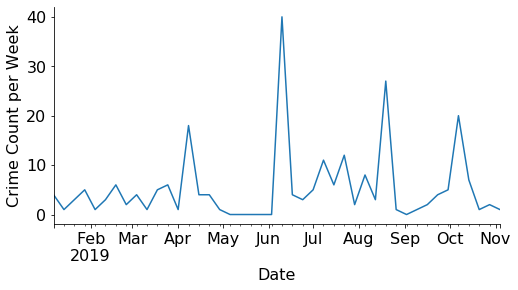

In [59]:
ax = (hate_crime_records
 .assign(c=1)
 .groupby(pd.Grouper(key='norm_date', freq='7D'))['c']
 .sum()
 .plot(figsize=(8, 4))
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Crime Count per Week')
ax.set_xlabel('Date');

In [82]:
import datetime
import dateutil
import math

In [87]:
plots = []
max_date = hate_crime_records['norm_date'].max()
for i in range(1, 7):
    proximal_window_start = max_date - datetime.timedelta(days=30 * i)
    distal_window_start = proximal_window_start - datetime.timedelta(days=30 * i)
    
    proximal_window = hate_crime_records['norm_date'].apply(lambda x: proximal_window_start <= x < max_date).sum()
    distal_window = hate_crime_records['norm_date'].apply(lambda x: distal_window_start <= x < proximal_window_start).sum()
    
    t = pd.Series({
        '0-%d' % (30*i): proximal_window,
        '%d-%d' % (30*i, 30*i*2): distal_window
    })
    plots.append(t)

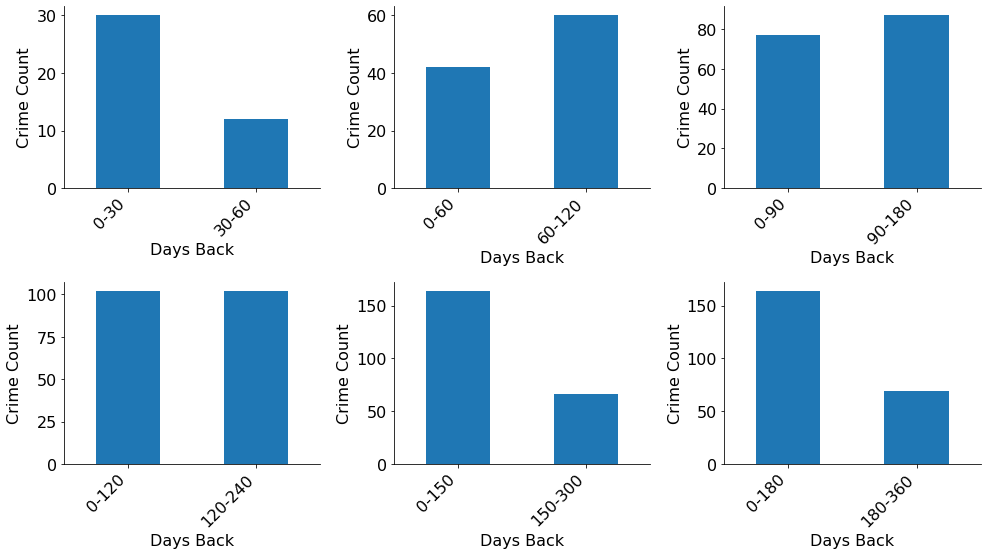

In [102]:
n_rows = 2
n_cols = math.ceil(len(plots)/ n_rows)

f, axarr = plt.subplots(n_rows, n_cols, figsize=(14, 8))
for i, data in enumerate(plots):
    ax = data.plot(ax=axarr[int(i/n_cols), i % n_cols], kind='bar')
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Crime Count')
    ax.set_xlabel('Days Back')
    
plt.tight_layout()

# time data

In [46]:
resp = requests.get('https://dev.api.xtown.la/api/crimes/hate_crimes/monthly?from=1262304000000')
time_data = resp.json()

In [51]:
time_df = pd.DataFrame(time_data['result']['data'])

In [53]:
import datetime

In [72]:
time_df.head()

,crime_count,month,year
0,11,1,2010
1,11,2,2010
2,20,3,2010
3,15,4,2010
4,16,5,2010


In [74]:
import matplotlib.pyplot as plt

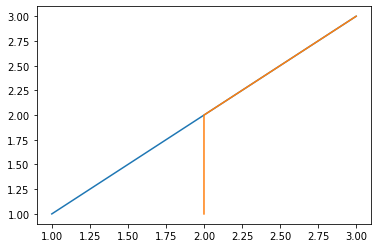

In [77]:
plt.plot([1,2,3], [1,2,3])
plt.plot([2,2,3], [1,2,3])

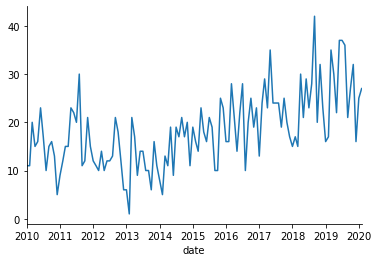

In [93]:
## pandas command
ax = (time_df
         .assign(date=lambda df: df.apply(lambda x: datetime.date(x['year'], x['month'], 1), axis=1))
         .set_index('date')
         ['crime_count']
         .astype(int)
         .plot()
)


## matplotlib command
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)